We look at capital insurance and denote:

\begin{eqnarray}
b: \mathbb{N} \to \mathbb{R}, \xi \mapsto b(\xi)
\end{eqnarray}

The benefit due if person dies at age $\xi$. We assume that the policy is issues at age $x$ and matures at age $s$. If the person suvives util $s$ a benefit of $m(s)$ is due. 

We use the normal notation regarding $v$ and $K$ and denote by $Z$ the random present value of this insurance. $Z$ can be calculated as follows:

\begin{eqnarray}
Z = \chi_{K_x < s-x} \times v^{K_x+1} \times b(x+K_x) + \chi_{K_x \ge s-x} \times v^{s-x} \times m(s)
\end{eqnarray}

Looking at the expected value we get

\begin{eqnarray}
\mathbb{E}[Z] = \sum_{k=0}^{s-x-1} {}_kp_x \, q_{x+k} \, v^{k+1} \times b(x+k) + {}_{s-x}p_x \times v^{s-x} \times m(s)
\end{eqnarray}

This can be calculated via commutation functions as follows

\begin{eqnarray}
A_x^{gen} := \mathbb{E}[Z] = \frac{1}{D_x}\left(\sum_{k=0}^{s-x-1}  C_{x+k} \times b(x+k) + D_{s} \times m(s) \right)
\end{eqnarray}

We can also calculate this recursively as follows:

\begin{eqnarray}
A_s^{gen} &=& m(s) \\
A_x^{gen} &=& q_x \times v \times b(x) + p_x \times v \times A_{x+1}^{gen}
\end{eqnarray}

We will use this in the following for our calculations and note that further details can be found in the script


In [8]:
import math
import numpy as np

filename = "EK95.txt"
#EKMF95 = np.loadtxt(filename, skiprows=0)

#print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(Qx(gender,x,t,param =param))

def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    if x>110: a[3]= 0
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class Capital:
    def __init__(self,Qx,i=0.02,omega=120,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit 
        self.psymM = ConstantBenefit # We incialise actually A_x
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.  #tp0
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x) # l_x v^x
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = self.psymM(s,param=param)
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px * qx * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
        
        n = s - x
        if n < periods:
            CF[n] = px * self.psymM(s,param=param)
            
        return(CF)
        

In [10]:
Ax = Capital(Qx, omega=120)
AxMed = Capital(QxMedieval)
AxNR = Capital(QxNoReduction)
AxEK95 = Capital(QxEK95)
print(Ax.CalcPV(0,25,100), Ax.CalcPV(1,25,100),AxMed.CalcPV(0,25,100))



0.2909436036784844 0.25913505928060987 0.6501634229767058


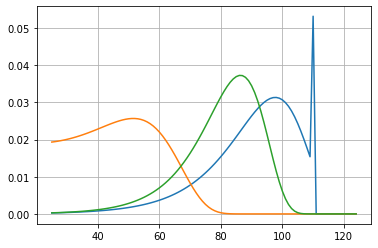

In [11]:
CF1 = Ax.CalcCF(0,25,110,periods=100)
CF2 = AxMed.CalcCF(0,25,110,periods=100)
CF3 = AxNR.CalcCF(0,25,110,periods=100)
plt.figure(1)
plt.plot(range(25, 25+len(CF1)),CF1,range(25, 25+len(CF2)),CF2,range(25, 25+len(CF3)),CF3)
plt.grid(True)

How does Expected Value move for changing ages, Example Ax:n


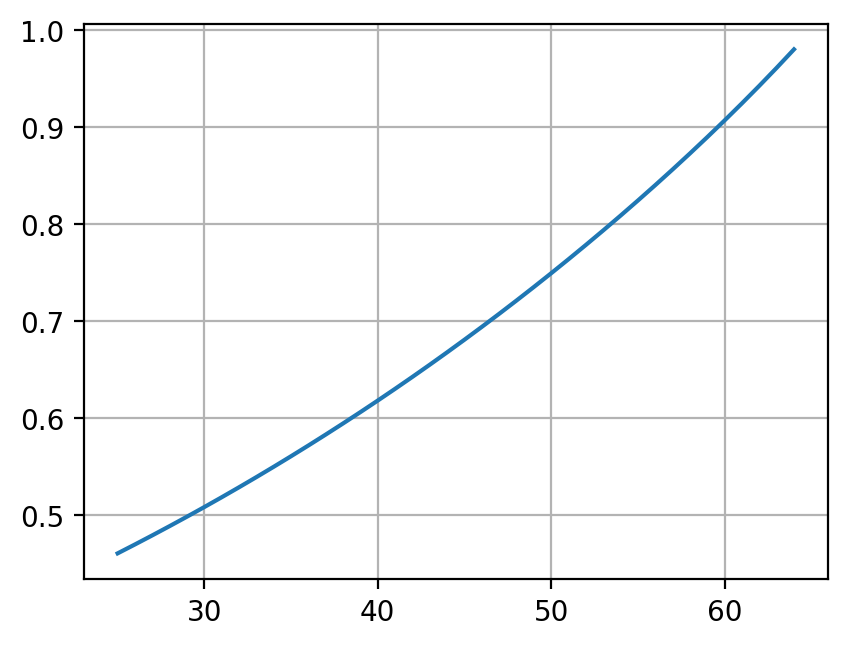

In [19]:
print("How does Expected Value move for changing ages, Example Ax:n")

x=range(25,65)
y = []
for i in x:
    y.append(Ax.CalcPV(0,i,65))

plt.figure(2)
plt.plot(x,y)
plt.grid(True)
    

How does Expected Value move for changing ages, Example Ax


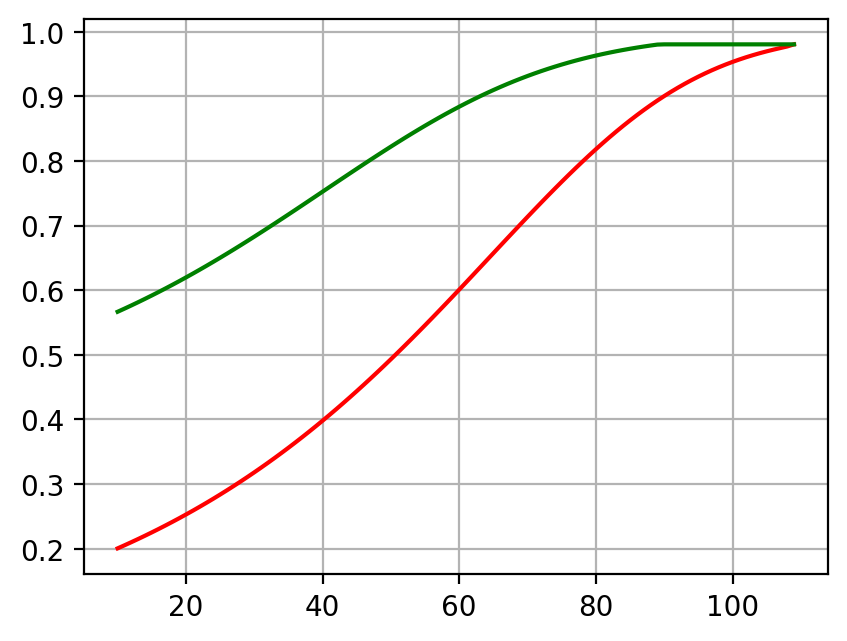

In [21]:
print("How does Expected Value move for changing ages, Example Ax")

x=range(10,110)
y = []
z = []
for i in x:
    y.append(Ax.CalcPV(0,i,110))
    z.append(AxMed.CalcPV(0,i,110))

plt.figure(3)
plt.plot(x,y,"r",x,z,"g")
plt.grid(True)

In [22]:
for i in range(64,59,-1):
    print(i)

64
63
62
61
60


In [23]:
print("Example Ax")
AxNRPV = AxNR.CalcPV(0,25,110)
AxNRPVCF = AxNR.CommFu(0,25,"M")/AxNR.CommFu(0,25,"D")
print(AxNRPV,AxNRPVCF,AxNRPV-AxNRPVCF )

Example Ax
0.34037088619382866 0.3403708861942261 -3.9745984281580604e-13


In [24]:
print("Example Ax:n")
x = 25
s = 65
n =  s - x
print("n = ", n)
AxNRPV = AxNR.CalcPV(0,x,65)
AxNRPVCF = (AxNR.CommFu(0,x,"M")-AxNR.CommFu(0,65,"M")+AxNR.CommFu(0,65,"D"))/AxNR.CommFu(0,x,"D")
print(AxNRPV,AxNRPVCF,AxNRPV-AxNRPVCF )


Example Ax:n
n =  40
0.46433991284240017 0.46433991284240006 1.1102230246251565e-16


In [25]:
print("Example Ax:n^1")
x = 30
s = 65
n =  s - x
AxNR.psymM = ZeroBenefit
print("n = ", n)
AxNRPV = AxNR.CalcPV(0,30,65)
AxNRPVCF = (AxNR.CommFu(0,30,"M")-AxNR.CommFu(0,65,"M"))/AxNR.CommFu(0,30,"D")
print(AxNRPV,AxNRPVCF,AxNRPV-AxNRPVCF )


Example Ax:n^1
n =  35
0.0673058681223249 0.06730586812232482 8.326672684688674e-17


In [13]:
print("Example Ax:n - EKM95")
x = 30
s = 65
n =  s - x
print("n = ", n)
AxNRPV = AxEK95.CalcPV(0,30,65)
AxNRPVCF = (AxEK95.CommFu(0,30,"M")-AxEK95.CommFu(0,65,"M")+AxEK95.CommFu(0,65,"D"))/AxEK95.CommFu(0,30,"D")
print(AxNRPV,AxNRPVCF,AxNRPV-AxNRPVCF )


Example Ax:n - EKM95
n =  35
0.5182265810717616 0.5182265810717616 0.0


In [14]:
(0.5182265810717616-0.511759031333641)/0.511759031333641*100

1.2637880998926752

We want to calculate the PV of a decreasing insurance with
x=30
n=35
Down from 100000 at x=30 to 0 at 65


In [12]:
def MyBenefit(x,param=[]):
    return(max(0,100000 * (65.-x)/35.))

In [13]:
print(MyBenefit(50))
print(MyBenefit(30))
print(MyBenefit(65))

42857.142857142855
100000.0
0


Single Prem Decr=  1543.543133499062
Single Prem Norm=  4273.810945103187


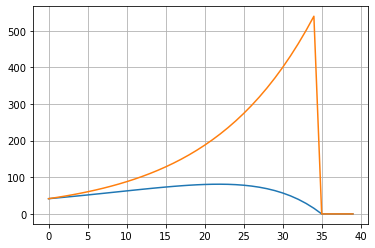

In [14]:
AxDecr = Capital(Qx)
AxDecr.psymM = ZeroBenefit
AxDecr.psymB = MyBenefit
AxNorm = Capital(Qx)
AxNorm.psymM = ZeroBenefit

print("Single Prem Decr= ",AxDecr.CalcPV(0,30,65))
print("Single Prem Norm= ",100000*AxNorm.CalcPV(0,30,65))


CFDecr = AxDecr.CalcCF(0,30,65,periods=40)
CFNorm = 100000*AxNorm.CalcCF(0,30,65,periods=40)
plt.figure(1)
plt.plot(range(len(CFDecr)),CFDecr, range(len(CFNorm)),CFNorm)
plt.grid(True)